In [2]:
# Boilerplate from Randy cheatsheet at https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [3]:
# Wide display
from IPython.core.display import display, HTML
display(HTML("<style>#notebook-container { margin-left:-14px; width:calc(100% + 27px) !important; }</style>"))

In [4]:
import csv, json, math, os, numbers, pandas, re, scipy, scipy.sparse, shutil
import struct, subprocess, sys, threading, time, urllib2

def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [5]:
def get_segments_from_ring(r):
    ret = set()
    for i in range(0, len(r)):
        ret.add((r[i - 1][0], r[i - 1][1], r[i][0], r[i][1]))
    return ret

def get_segments_from_polygon(p):
    return set.union(*[get_segments_from_ring(r) for r in p])

def get_segments_from_multipolygon(mp):
    return set.union(*[get_segments_from_polygon(p) for p in mp])

def get_segments(g):
    if 'features' in g:
        return set.union(*[get_segments(f) for f in g['features']])
    elif 'geometry' in g:
        if g['geometry']['type'] == 'Polygon':
            return get_segments_from_polygon(g['geometry']['coordinates'])
        elif g['geometry']['type'] == 'MultiPolygon':
            return get_segments_from_multipolygon(g['geometry']['coordinates'])
        else:
            raise Exception('unrecognized geometry type %s' % g['geometry']['type'])
    else:
        raise 'unrecognized type'
        
def LonLatToWebMercator(lon, lat):
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def WebMercatorToLonLat(x,y):
    lat = math.atan(math.exp((128.0 - y) * math.pi / 128.0)) * 360.0 / math.pi - 90.0
    lon = x * 360.0 / 256.0 - 180.0
    return [lon, lat]

def project_and_binarize_segment(segment, dest):
    (x1, y1) = LonLatToWebMercator(segment[0], segment[1])
    (x2, y2) = LonLatToWebMercator(segment[2], segment[3])
    dest.write(struct.pack('<ffff', x1, y1, x2, y2))

def binarize_geojson_outlines(src, dest):
    gj = json.load(open(src))
    print 'Read %d features from %s' % (len(gj['features']), src)
    segments = get_segments(gj)
    print '%d segments' % len(segments)

    try:
        os.makedirs(os.path.dirname(dest))
    except OSError:
        pass
        
    out = open(dest + '.tmp', 'w')
    for segment in segments:
        project_and_binarize_segment(segment, out)
    out.close()
    os.rename(dest + '.tmp', dest)
    print 'Created %s (%d segments)' % (dest, os.stat(dest).st_size / 16)
        

# Schools

## 9-12

In [9]:
# These are from A+ schools and didn't pan out because they've got all the streets drawn in
binarize_geojson_outlines('allegheny_county/schools/9_12.json', 
                          'allegheny_county/schools/9_12.bin')

Read 4 features from allegheny_county/schools/9_12.json
234618 segments
Created allegheny_county/schools/9_12.bin (234618 segments)


In [49]:
# These are from Alvin
# Project to WGS84 (standard lat-lon)
g = gpd.read_file('allegheny_county/schools/alvin/SABS_1314_High.shp').to_crs(epsg=4326)


In [38]:
g

,SrcName,ncessch,schnam,leaid,updateDate,gslo,gshi,defacto,stAbbrev,sLevel,openEnroll,MultiBdy,Shape_Leng,Shape_Area,geometry
0,None,010000500871,ALBERTVILLE HIGH SCH,0100005,2015-03-31,09,12,Yes,AL,3,0,0,121162.074569,6.899052e+07,(POLYGON ((-86.27445100009017 34.2581160003795...
1,None,010000600878,DOUGLAS HIGH SCH,0100006,2014-05-14,09,12,No,AL,3,0,0,121324.157984,2.731131e+08,(POLYGON ((-86.2510350004554 34.25266299945552...
2,None,010000600883,KATE D SMITH DAR HIGH SCH,0100006,2014-05-14,09,12,No,AL,3,0,0,143461.673235,3.899686e+08,(POLYGON ((-86.14981299959959 34.5333470000041...
3,None,010000601585,BRINDLEE MT HIGH SCH,0100006,2014-05-14,09,12,No,AL,3,0,0,168542.651329,4.019228e+08,(POLYGON ((-86.46229800066357 34.3101070000090...
4,Not Provided,010000699993,Unassigned,0100006,2014-11-14,09,12,No,AL,3,0,0,301327.961025,3.059758e+08,(POLYGON ((-86.25772999980684 34.3018509996733...
5,Hoover High School,010000700251,HOOVER HIGH SCH,0100007,2014-08-14,09,12,No,AL,3,0,0,181537.452980,7.225248e+07,(POLYGON ((-86.90011799989847 33.3150610007074...
6,Spain Park High School,010000701456,SPAIN PARK HIGH SCH,0100007,2014-08-14,09,12,No,AL,3,0,0,234745.336042,5.170779e+07,(POLYGON ((-86.69563500039018 33.4247390001874...
7,Bob Jones,010000800831,BOB JONES HIGH SCH,0100008,2014-06-03,09,12,No,AL,3,0,0,60039.043036,3.131623e+07,(POLYGON ((-86.73686300063343 34.7533529996411...
8,James Clemens,010000802198,JAMES CLEMENS HIGH SCH,0100008,2014-06-03,09,12,No,AL,3,0,0,87910.197531,4.191231e+07,(POLYGON ((-86.77222599974782 34.7477870002524...
9,Not Provided,010000899993,Unassigned,0100008,2014-11-14,09,12,No,AL,3,0,0,26439.420862,3.792805e+06,(POLYGON ((-86.82872001921915 34.7293280090085...


In [63]:
a1 = g[g.schnam.str.contains('ALLDER')]
a1

,SrcName,ncessch,schnam,leaid,updateDate,gslo,gshi,defacto,stAbbrev,sLevel,openEnroll,MultiBdy,Shape_Leng,Shape_Area,geometry
10474,ALLDERDICE 9-12,421917000409,PITTSBURGH ALLDERDICE HS,4219170,2014-08-28,09,12,No,PA,3,0,0,46927.547571,3.390293e+07,(POLYGON ((-79.93066292459316 40.4635014789670...


In [82]:
pps_hs = g[g.leaid== '4219170']
pps_hs

,SrcName,ncessch,schnam,leaid,updateDate,gslo,gshi,defacto,stAbbrev,sLevel,openEnroll,MultiBdy,Shape_Leng,Shape_Area,geometry
10474,ALLDERDICE 9-12,421917000409,PITTSBURGH ALLDERDICE HS,4219170,2014-08-28,09,12,No,PA,3,0,0,46927.547571,3.390293e+07,(POLYGON ((-79.93066292459316 40.4635014789670...
10475,CARRICK 9-12,421917000412,PITTSBURGH CARRICK HS,4219170,2014-08-28,09,12,No,PA,3,0,0,28962.159141,1.767297e+07,POLYGON ((-79.99712727349593 40.42919705025344...
10476,NORTH SIDE HIGH SCHOOL 9-12,421917000416,PITTSBURGH PERRY HS,4219170,2014-08-28,09,12,No,PA,3,0,0,31557.400813,2.300497e+07,(POLYGON ((-80.01079599935811 40.5007499995275...
10477,BRASHEAR 9-12,421917006915,PITTSBURGH BRASHEAR HS,4219170,2014-08-28,09,12,No,PA,3,0,0,64897.453660,3.226691e+07,POLYGON ((-80.05062161036452 40.46254662432019...
10478,Not Provided,421917099993,Unassigned,4219170,2014-11-18,09,12,No,PA,3,0,0,74713.044413,7.552346e+06,(POLYGON ((-79.91501499971841 40.4887999995496...


In [65]:
a2 = g[g.schnam.str.contains('BRASHE')]
a2

,SrcName,ncessch,schnam,leaid,updateDate,gslo,gshi,defacto,stAbbrev,sLevel,openEnroll,MultiBdy,Shape_Leng,Shape_Area,geometry
10477,BRASHEAR 9-12,421917006915,PITTSBURGH BRASHEAR HS,4219170,2014-08-28,09,12,No,PA,3,0,0,64897.45366,3.226691e+07,POLYGON ((-80.05062161036452 40.46254662432019...


In [66]:
a3 = g[g.schnam.str.contains('CARRICK')]
a3

,SrcName,ncessch,schnam,leaid,updateDate,gslo,gshi,defacto,stAbbrev,sLevel,openEnroll,MultiBdy,Shape_Leng,Shape_Area,geometry
10475,CARRICK 9-12,421917000412,PITTSBURGH CARRICK HS,4219170,2014-08-28,09,12,No,PA,3,0,0,28962.159141,1.767297e+07,POLYGON ((-79.99712727349593 40.42919705025344...


In [87]:
a4 = g[g.schnam.str.contains('PITTSBURGH PERRY HS')]
a4

,SrcName,ncessch,schnam,leaid,updateDate,gslo,gshi,defacto,stAbbrev,sLevel,openEnroll,MultiBdy,Shape_Leng,Shape_Area,geometry
10476,NORTH SIDE HIGH SCHOOL 9-12,421917000416,PITTSBURGH PERRY HS,4219170,2014-08-28,09,12,No,PA,3,0,0,31557.400813,2.300497e+07,(POLYGON ((-80.01079599935811 40.5007499995275...


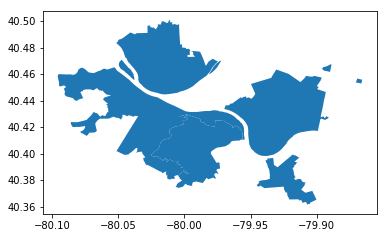

In [88]:
a=a1.append(a2.append(a3.append(a4)))
a.plot()

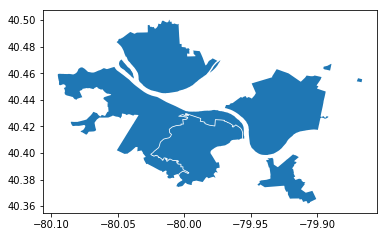

In [89]:
# Inset by ~25 m
b=a.geometry.buffer(-0.0003)
b.plot()

In [90]:
try:
    os.unlink('allegheny_county/schools/alvin/alvin-9_12.geojson')
except:
    pass
b.to_file('allegheny_county/schools/alvin/alvin-9_12.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/alvin-9_12.geojson', 
                          'allegheny_county/alvin-9_12.bin')

Read 4 features from allegheny_county/schools/alvin/alvin-9_12.geojson
11861 segments
Created allegheny_county/alvin-9_12.bin (11861 segments)


## Load in all Alvin's files and subset on PPS (leaid== '4219170')

In [ ]:
# These are from Alvin
# Project to WGS84 (standard lat-lon)
m = gpd.read_file('allegheny_county/schools/alvin/SABS_1314_Middle.shp').to_crs(epsg=4326)

In [83]:
pps_m = m[m.leaid== '4219170']
pps_m

,SrcName,ncessch,schnam,leaid,updateDate,gslo,gshi,defacto,stAbbrev,sLevel,openEnroll,MultiBdy,Shape_Leng,Shape_Area,geometry
10379,None,421917000414,PITTSBURGH ALLEGHENY 6-8,4219170,2015-03-25,06,08,No,PA,2,1,0,110971.657900,1.492220e+08,POLYGON ((-80.09550899996364 40.45906399978978...
10380,None,421917000598,PITTSBURGH CLASSICAL 6-8,4219170,2015-03-25,06,08,No,PA,2,1,0,110971.657900,1.492220e+08,POLYGON ((-79.88724000004068 40.49115100018457...
10381,SOUTH BROOK 6-8,421917000599,PITTSBURGH SOUTH BROOK 6-8,4219170,2014-08-28,06,08,No,PA,2,0,0,21160.865056,1.024995e+07,POLYGON ((-79.99681103286294 40.41140139219484...
10382,SOUTH HILLS 6-8,421917006749,PITTSBURGH SOUTH HILLS 6-8,4219170,2014-08-28,06,08,No,PA,2,0,0,51734.493835,2.627958e+07,(POLYGON ((-80.02576710376452 40.4440365723219...
10383,ARSENAL 6-8,421917006751,PITTSBURGH ARSENAL 6-8,4219170,2014-08-28,06,08,No,PA,2,0,0,16542.686914,9.088454e+06,POLYGON ((-79.95405040457085 40.47732332898446...
10384,STERRETT,421917007039,PITTSBURGH STERRETT 6-8,4219170,2014-08-28,06,08,No,PA,2,0,0,26662.828226,1.040017e+07,POLYGON ((-79.90192786336409 40.45864869037217...
10385,SCHILLER 6-8,421917007132,PITTSBURGH SCHILLER 6-8,4219170,2014-08-28,06,08,No,PA,2,0,0,14176.271551,3.532733e+06,(POLYGON ((-79.98579899971044 40.4716349999480...
10386,Not Provided,421917099992,Unassigned,4219170,2014-11-18,06,08,No,PA,2,0,0,74712.070222,7.552230e+06,POLYGON ((-79.91501499971841 40.48879999954961...


In [75]:
o = gpd.read_file('allegheny_county/schools/alvin/SABS_1314_Other.shp').to_crs(epsg=4326)

In [84]:
pps_o = o[o.leaid== '4219170']
pps_o

,SrcName,ncessch,schnam,leaid,updateDate,gslo,gshi,defacto,stAbbrev,sLevel,openEnroll,MultiBdy,Shape_Leng,Shape_Area,geometry
1549,Not provided,421917006989,PITTSBURGH SCIENCE AND TECHNOLOGY ACADEM,4219170,2014-08-28,06,12,No,PA,4,0,0,151625.203663,1.416698e+08,(POLYGON ((-79.91833031574764 40.4881154409219...
1550,Not provided,421917006995,PITTSBURGH OBAMA 6-12,4219170,2014-08-28,06,12,No,PA,4,0,0,151625.203663,1.416698e+08,(POLYGON ((-79.91833031574764 40.4881154409219...
1551,Not provided,421917007014,PITTSBURGH CAPA 6-12,4219170,2014-08-28,06,12,No,PA,4,0,0,151625.203663,1.416698e+08,(POLYGON ((-79.91833031574764 40.4881154409219...
1552,U PREP 6-8,421917007345,PITTSBURGH MILLIONES 6-12,4219170,2014-08-28,06,12,No,PA,4,0,1,23506.317679,2.188600e+07,"POLYGON ((-79.91833031574764 40.4881154409219,..."
1553,WESTINGHOUSE 6-8,421917007412,ACADAMY AT WESTINGHOUSE,4219170,2014-08-28,06,12,No,PA,4,0,0,26494.654656,1.290974e+07,(POLYGON ((-79.91146304152937 40.4863735327508...
1554,None,421917007505,PITTSBURGH ONLINE ACADEMY,4219170,2015-03-25,04,12,No,PA,4,1,0,110971.657900,1.492220e+08,POLYGON ((-80.09550899996364 40.45906399978978...


In [76]:
p = gpd.read_file('allegheny_county/schools/alvin/SABS_1314_Primary.shp').to_crs(epsg=4326)

In [85]:
pps_p = p[p.leaid== '4219170']
pps_p

,SrcName,ncessch,schnam,leaid,updateDate,gslo,gshi,defacto,stAbbrev,sLevel,openEnroll,MultiBdy,Shape_Leng,Shape_Area,geometry
31579,SPRING HILL K-5,421917000045,PITTSBURGH SPRING HILL K-5,4219170,2014-08-28,PK,05,No,PA,1,0,0,14176.271551,3.532733e+06,(POLYGON ((-79.98579899971044 40.4716349999480...
31580,BANKSVILLE K-5,421917000253,PITTSBURGH BANKSVILLE K-5,4219170,2014-08-28,KG,05,No,PA,1,0,0,11726.221988,3.233044e+06,POLYGON ((-80.02977414595881 40.41932775446114...
31581,WOOLSLAIR K-5,421917000255,PITTSBURGH WOOLSLAIR K-5,4219170,2014-08-28,KG,05,No,PA,1,0,0,14645.129057,5.408960e+06,"POLYGON ((-79.9580150382162 40.46526818494802,..."
31582,None,421917000326,PITTSBURGH CARMALT K-8,4219170,2015-03-25,PK,08,No,PA,1,1,0,110971.657900,1.492220e+08,POLYGON ((-80.09550899996364 40.45906399978978...
31583,CONCORD PK-5,421917000330,PITTSBURGH CONCORD K-5,4219170,2014-08-28,PK,05,No,PA,1,0,0,9773.876765,3.219858e+06,POLYGON ((-79.97665699967281 40.39456500079835...
31584,None,421917000351,PITTSBURGH MONTESSORI K-8,4219170,2015-03-25,PK,08,No,PA,1,1,0,110971.657900,1.492220e+08,POLYGON ((-80.09550899996364 40.45906399978978...
31585,MINADEO PK-5,421917000363,PITTSBURGH MINADEO K-5,4219170,2014-08-28,PK,05,No,PA,1,0,0,26662.828231,1.040017e+07,POLYGON ((-79.90192786336409 40.45864869037217...
31586,MORROW PK-8,421917000365,PITTSBURGH MORROW K-8,4219170,2014-08-28,PK,08,No,PA,1,0,0,16929.677189,9.708969e+06,POLYGON ((-80.01079599935811 40.50074999952759...
31587,PHILLIPS K-5,421917000395,PITTSBURGH PHILLIPS K-5,4219170,2014-08-28,KG,05,No,PA,1,0,0,11824.988594,2.922687e+06,POLYGON ((-79.97462054527823 40.43241090095174...
31588,GRANDVIEW K-5,421917000400,PITTSBURGH GRANDVIEW K-5,4219170,2014-08-28,KG,05,No,PA,1,0,0,9755.774052,2.617589e+06,POLYGON ((-79.99712727349593 40.42919705025344...


# Generalize

In [160]:
def accum_catchments(src,nce_arr):
    all=pd.DataFrame()

    for nce in nce_arr:
        n = src[src.ncessch == nce]
        if(n.empty):
            print "Missing %s"%(nce)
        else:
            if(all.empty):
                all = n
                #print "Got first, len = %d" % (len(all))
            else:
                all = all.append(n)
                #print "Got another, len = %d" % (len(all))
    # Inset by ~25 m
    all_eroded= all.geometry.buffer(-0.0003)
    return all_eroded

## 6-12

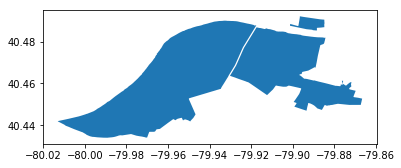

In [170]:
nce_6_12 = ['421917007412','421917007345']
catch_6_12 = accum_catchments(pps_o,nce_6_12)
catch_6_12.plot()

In [171]:
try:
    os.unlink('allegheny_county/schools/alvin/alvin-6_12.geojson')
except:
    pass
catch_6_8.to_file('allegheny_county/schools/alvin/alvin-6_12.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/alvin-6_12.geojson', 
                          'allegheny_county/alvin-6_12.bin')

Read 5 features from allegheny_county/schools/alvin/alvin-6_12.geojson
9245 segments
Created allegheny_county/alvin-6_12.bin (9245 segments)


## 6-8

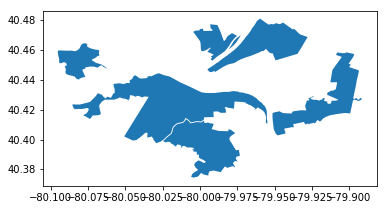

In [350]:
nce_6_8 = ['421917006751','421917007132','421917000599','421917006749',
          '421917007039']
catch_6_8 = accum_catchments(pps_m,nce_6_8)
catch_6_8.plot()

In [124]:
try:
    os.unlink('allegheny_county/schools/alvin/alvin-6_8.geojson')
except:
    pass
catch_6_8.to_file('allegheny_county/schools/alvin/alvin-6_8.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/alvin-6_8.geojson', 
                          'allegheny_county/alvin-6_8.bin')

Read 5 features from allegheny_county/schools/alvin/alvin-6_8.geojson
9245 segments
Created allegheny_county/alvin-6_8.bin (9245 segments)


## K-8

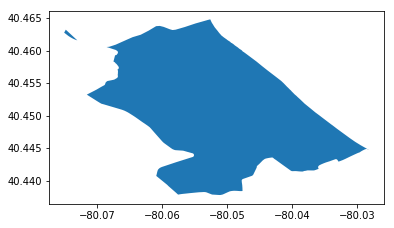

In [327]:
nce_k_8 = ['421917006769','421917006755','421917006022','421917006028',
           '421917006761','421917007468','421917006750','421917006766',
           '421917000365','421917006757']

catch_k_8 = accum_catchments(pps_p,nce_k_8)
catch_k_8.plot()

In [137]:
try:
    os.unlink('allegheny_county/schools/alvin/alvin-k_8.geojson')
except:
    pass
catch_k_8.to_file('allegheny_county/schools/alvin/alvin-k_8.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/alvin-k_8.geojson', 
                          'allegheny_county/alvin-k_8.bin')

Read 10 features from allegheny_county/schools/alvin/alvin-k_8.geojson
9644 segments
Created allegheny_county/alvin-k_8.bin (9644 segments)


## K-5

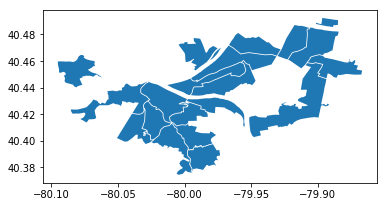

In [163]:
nce_k_5 = ['421917003409','421917000253','421917006019','421917000330',
           '421917007411','421917006026','421917000400','421917000979',
           '421917000975','421917000363','421917000395','421917000684',
           '421917000045','421917000991','421917000600','421917006756',
           '421917006747','421917000255']
catch_k_5 = accum_catchments(pps_p,nce_k_5)
catch_k_5.plot()

In [164]:
try:
    os.unlink('allegheny_county/schools/alvin/alvin-k_5.geojson')
except:
    pass
catch_k_8.to_file('allegheny_county/schools/alvin/alvin-k_5.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/alvin-k_5.geojson', 
                          'allegheny_county/alvin-k_5.bin')

Read 18 features from allegheny_county/schools/alvin/alvin-k_5.geojson
18845 segments
Created allegheny_county/alvin-k_5.bin (18845 segments)


# Unified 2015/2016 data

In [227]:
# Found newer files that have all levels together from https://nces.ed.gov/programs/edge/sabs
# Downloaded https://nces.ed.gov/programs/edge/data/SABS_1516.zip to
# hal15:~/uwsgi/dotmaptiles/data-visualization-tools/examples/lodes/allegheny_county/schools/alvin
p_1516 = gpd.read_file('allegheny_county/schools/alvin/SABS_1516/SABS_1516.shp').to_crs(epsg=4326)
p_1516['ncessch'] = p_1516['ncessch'].astype(numpy.str)

In [228]:
pps_1516_raw = p_1516[p_1516.leaid== '4219170']
pps_1516=pps_1516_raw.copy()
pps_1516=pps_1516.set_index('ncessch')


# PPS specs google sheet

In [240]:
# Read in PPS specs google sheet
#  https://docs.google.com/spreadsheets/d/1-6_LTxtRvdBnXfFOmfjUrX_TCRA4OF6G0YsLX2VS6Mc/edit#gid=0
pps_specs_path = "https://docs-proxy.cmucreatelab.org/spreadsheets/d/1-6_LTxtRvdBnXfFOmfjUrX_TCRA4OF6G0YsLX2VS6Mc/export?format=csv&gid=0"
#pps_specs_csv_all = pd.read_csv(pps_specs_path,dtype={'ncessch':np.int64,'nbhd':np.str})
pps_specs_csv_all = pd.read_csv(pps_specs_path,dtype={'ncessch':np.str,'nbhd':np.str},keep_default_na=False)

# Take the subset that we know the ncessch value for
pps_specs_csv_known = pps_specs_csv_all[(pps_specs_csv_all.nbhd!= '') & (pps_specs_csv_all.ncessch!='')]
pps_specs_csv_known

# Set index to ncessch
pps_specs_csv_known=pps_specs_csv_known.copy().set_index('ncessch')

# Take the subset that are neighborhood schools
pps_specs_csv_nbhd = pps_specs_csv_known[pps_specs_csv_known.nbhd== 'y']
#pps_specs_csv_nbhd

In [241]:
# Create a column for category: 0=non-neighborhood, 1=neighborhood, 2=community
pps_specs_csv_known['category']=pps_specs_csv_known[['nbhd', 'community']].apply(lambda x: (1 if x[0]=='y' else 0)+(1 if x[1]=='y' else 0) , axis=1)


In [243]:
pps_specs_csv_known[['Name','category']]

,Name,category
ncessch,,
421917007014,CAPA 6-12,0
421917007345,Milliones 6-12,1
421917006995,Obama 6-12,0
421917006989,Sci-Tech 6-12,0
421917007412,Westinghouse 6-12,2
421917000414,Allegheny 6-8,0
421917006751,Arsenal 6-8,1
421917000598,Classical 6-8,0
421917007132,Schiller 6-8,1


In [329]:
# Create a table that only contains the PPS neighborhood schools and has all the columns from both the 
# geopandas and csv
pps_1516_nhbd = pd.merge(pps_1516, pps_specs_csv_nbhd, on='ncessch', how='inner')
#pps_1516_nhbd

In [330]:
pre_ks = pps_1516_nhbd[pps_1516_nhbd.gslo == 'PK']
#pre_ks

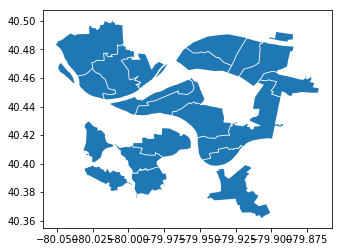

In [331]:
# Inset by ~25 m
pre_ks_eroded= pre_ks.geometry.buffer(-0.0003)
pre_ks_eroded.plot()

In [332]:
try:
    os.unlink('allegheny_county/schools/alvin/schools_1516-prek.geojson')
except:
    pass
pre_ks_eroded.to_file('allegheny_county/schools/alvin/schools_1516-prek.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/schools_1516-prek.geojson', 
                          'allegheny_county/schools_1516-prek.bin')

Read 19 features from allegheny_county/schools/alvin/schools_1516-prek.geojson
18004 segments
Created allegheny_county/schools_1516-prek.bin (18004 segments)


In [333]:
def write_schools_geometry(df, json_path, bin_path):
    # Inset by ~25 m
    df_eroded= df.geometry.buffer(-0.0003)
    df.plot()
    try:
        os.unlink(json_path)
    except:
        pass
    df_eroded.to_file(json_path, driver="GeoJSON")
    binarize_geojson_outlines(json_path, 
                              bin_path)

In [411]:
def write_schools_csv(df, val_colname, include_sizes, include_latlon, out_path):
    date_range = range(2017, 2019)
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    latlon_str=''
    if(include_latlon):
        latlon_str='lat,lon,'
    out.write("id,%s%s\n" % (latlon_str,",".join(map(str,date_range))))
    
    for i in range(0,len(df.index)):
        # Make sure we know lat/lon
        if(include_latlon and (pd.isnull(df['Latitude'][i]) or df['Latitude'][i]=='' or
            pd.isnull(df['Longitude'][i]) or df['Longitude'][i]=='')):
            continue
            
        #Output two rows, both with the same label.  First row is bubble size.  Second row is 0 - 1 for status
        
        # Bubble size row -- size is 20 if not set, or size if set
        size_row=[str(df.index[i])]
        if(include_latlon):
            size_row.append(df['Latitude'][i])
            size_row.append(df['Longitude'][i])

        for year in date_range:
            #if(df['Size'][i]!=''):
            if(not pd.isnull(df['Size'][i]) and df['Size'][i]!=''):
                size_row.append(int(df['Size'][i]))
            else:
                size_row.append(20)
        
        # Bubble color row -- value depends on status
        color_row=[str(df.index[i])]
        if(include_latlon):
            color_row.append(df['Latitude'][i])
            color_row.append(df['Longitude'][i])

        for year in date_range:
            color_val=0
            if(not pd.isnull(df[val_colname][i]) and df[val_colname][i]!=''):
                color_val=df[val_colname][i]
            color_row.append(color_val)
            
        # Write both rows for this property out here if include_sizes is true.  
        # Otherwise just do the color row
        if(include_sizes):
            out.write('%s\n' % (",".join(map(str,size_row))))
        out.write('%s\n' % (",".join(map(str,color_row))))

    out.close()

In [412]:
write_schools_csv(pre_ks,'chronic_absences',True,True,'allegheny_county/schools_1516-bubbles-prek.csv')
write_schools_csv(pre_ks,'chronic_absences',False,False,'allegheny_county/schools_1516-chor-prek.csv')


## 9-12

Read 4 features from allegheny_county/schools/alvin/schools_1516-9_12.geojson
12765 segments
Created allegheny_county/schools_1516-9_12.bin (12765 segments)


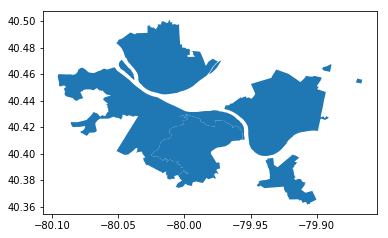

In [413]:
hs = pps_1516_nhbd[pps_1516_nhbd.Type == '9-12']
write_schools_geometry(hs, 'allegheny_county/schools/alvin/schools_1516-9_12.geojson', 
                       'allegheny_county/schools_1516-9_12.bin')
write_schools_csv(hs,'chronic_absences',True,True,'allegheny_county/schools_1516-bubbles-9_12.csv')
write_schools_csv(hs,'chronic_absences',False,False,'allegheny_county/schools_1516-chor-9_12.csv')

In [414]:
## K-5

Read 18 features from allegheny_county/schools/alvin/schools_1516-k_5.geojson
19359 segments
Created allegheny_county/schools_1516-k_5.bin (19359 segments)


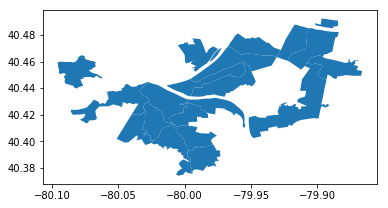

In [415]:
K5 = pps_1516_nhbd[pps_1516_nhbd.Type == 'K-5']
write_schools_geometry(K5, 'allegheny_county/schools/alvin/schools_1516-k_5.geojson', 
                       'allegheny_county/schools_1516-k_5.bin')
write_schools_csv(K5,'chronic_absences',True,True,'allegheny_county/schools_1516-bubbles-k_5.csv')
write_schools_csv(K5,'chronic_absences',False,False,'allegheny_county/schools_1516-chor-k_5.csv')

In [416]:
## K-8

Read 10 features from allegheny_county/schools/alvin/schools_1516-k_8.geojson
9741 segments
Created allegheny_county/schools_1516-k_8.bin (9741 segments)


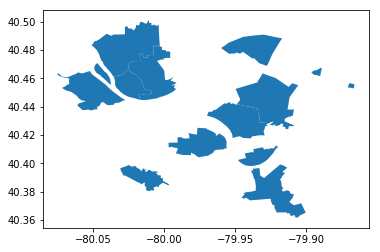

In [417]:
K8 = pps_1516_nhbd[pps_1516_nhbd.Type == 'K-8']
write_schools_geometry(K8, 'allegheny_county/schools/alvin/schools_1516-k_8.geojson', 
                       'allegheny_county/schools_1516-k_8.bin')
write_schools_csv(K8,'chronic_absences',True,True,'allegheny_county/schools_1516-bubbles-k_8.csv')
write_schools_csv(K8,'chronic_absences',False,False,'allegheny_county/schools_1516-chor-k_8.csv')

In [418]:
## 6-8

Read 5 features from allegheny_county/schools/alvin/schools_1516-6_8.geojson
9649 segments
Created allegheny_county/schools_1516-6_8.bin (9649 segments)


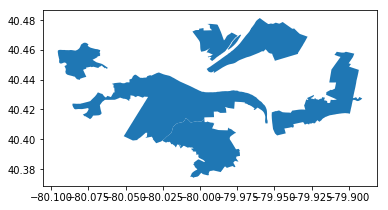

In [419]:
m_68 = pps_1516_nhbd[pps_1516_nhbd.Type == '6-8']
write_schools_geometry(m_68, 'allegheny_county/schools/alvin/schools_1516-6_8.geojson', 
                       'allegheny_county/schools_1516-6_8.bin')
write_schools_csv(m_68,'chronic_absences',True,True,'allegheny_county/schools_1516-bubbles-6_8.csv')
write_schools_csv(m_68,'chronic_absences',False,False,'allegheny_county/schools_1516-chor-6_8.csv')

In [420]:
## 6-12

Read 2 features from allegheny_county/schools/alvin/schools_1516-6_12.geojson
2413 segments
Created allegheny_county/schools_1516-6_12.bin (2413 segments)


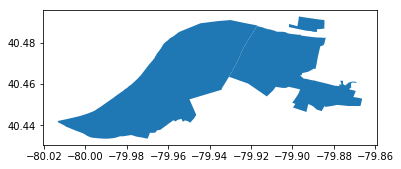

In [421]:
m_612 = pps_1516_nhbd[pps_1516_nhbd.Type == '6-12']
write_schools_geometry(m_612, 'allegheny_county/schools/alvin/schools_1516-6_12.geojson', 
                       'allegheny_county/schools_1516-6_12.bin')
write_schools_csv(m_612,'chronic_absences',True,True,'allegheny_county/schools_1516-bubbles-6_12.csv')
write_schools_csv(m_612,'chronic_absences',False,False,'allegheny_county/schools_1516-chor-6_12.csv')


# A+ Schools data files

In [109]:
def schoolname_to_ncessch(schoolname, stype):
    name_match_vec = (pps_specs_csv_known.Name.str.contains("^%s"%(schoolname),regex=True))
    if(stype):
        name_match_vec = name_match_vec & (pps_specs_csv_known.Type==stype)
    matching_row = pps_specs_csv_known[name_match_vec]
    if(len(matching_row)==1):
        return matching_row.iloc[0].name
    else:
        return None
    

# Enrollment

In [295]:
enrollment_map={}
enrollment_colnames=['School Name','Total enrollment','Black enrollment','White enrollment','Asian enrollment','Hispanic enrollment','Other enrollment']

# Create list of nsessch values for combined 9-12, 6-8, and K-5.  Put both 9-12 and 6-12 in 9-12, all three of K-8, 6-12, and 6-8 in 6-8, and both K-5 and K-8 in K-5
cstype_map = {'9-12':['9-12','6-12'],
             '6-8':['K-8','6-12','6-8'],
             'K-5':['K-5','K-8']}
# For each combined school type, hold onto a list of nsessch values for it.  The ones from 6-12 and K-8 will each appear multiple times.
nsessch_map = {}

# Populate nsessch_map for each combined school type
for cstype_i in cstype_map:
    cstype_match_vec_i = pd.Series(False,pps_specs_csv_known.index)
    for stype_j in cstype_map[cstype_i]:
        stype_match_vec_j=(pps_specs_csv_known.Type==stype_j)                                               
        cstype_match_vec_i = cstype_match_vec_i | stype_match_vec_j
    
    nsessch_map[cstype_i] = list(pps_specs_csv_known[cstype_match_vec_i].index)

### 2012 Enrollment? 

In [330]:
# In 2012 folder at A+ Schools, updated 10/16/12: 
# https://www.dropbox.com/home/Report%20to%20the%20Community/2012?preview=enroll_att_lunch_etc_12+FINAL+v2.xlsx
path_aps_2012="allegheny_county/schools/aplus_schools/enroll_att_lunch_etc_12 FINAL v2.xlsx"
xls_aps_2012 = pd.ExcelFile(path_aps_2012, header=None, index_col=None)
xls_aps_2012.sheet_names

[u'elementary',
 u'K8',
 u'middle',
 u'6-12',
 u'highschool',
 u'definitions',
 u'all schools']

In [351]:
# Special case this one to name the first two columns.  If leftmost columns have no name, they get used as a multi-index
    colnames_2012=['Name',"Type", u'tch_totn12', u'tch_pctatt12',
                     u'attend12', u'enroll12', u'pct_black12', u'pct_white12',
                     u'pct_multi12', u'pct_asian12', u'pct_hisp12', u'pct_NA12',
                     u'pct_oth12', u'lunch_12', u'inc_per100_']

df_aps_2012=pd.read_excel(xls_aps_2012, 'all schools', index_col=None, header=None,skiprows=1, names=colnames_2012)
df_aps_2012

,Name,Type,tch_totn12,tch_pctatt12,attend12,enroll12,pct_black12,pct_white12,pct_multi12,pct_asian12,pct_hisp12,pct_NA12,pct_oth12,lunch_12,inc_per100_
0,Pittsburgh Allegheny 6-8,6-8,22.0,95.204664,91.68,365,0.643836,0.271233,0.068493,NaN,NaN,NaN,NaN,0.810959,12.137203
1,Pittsburgh Arsenal 6-8,6-8,17.0,92.685556,94.82,218,0.825688,0.087156,NaN,NaN,NaN,NaN,0.087156,0.839450,36.507937
2,Pittsburgh Classical 6-8,6-8,26.0,91.804269,92.9,328,0.457317,0.442073,0.073171,NaN,NaN,NaN,NaN,0.795732,4.639175
3,Pittsburgh Schiller 6-8,6-8,16.0,95.337042,90.46,240,0.658333,0.270833,0.054167,NaN,NaN,NaN,NaN,0.866667,15.384615
4,Pittsburgh South Brook 6-8,6-8,32.0,94.977094,90.68,472,0.167373,0.726695,0.082627,NaN,NaN,NaN,0.023305,0.673729,9.170306
5,Pittsburgh South Hills 6-8,6-8,33.0,93.225448,93.19,506,0.286561,0.450593,0.069170,0.116601,0.073123,NaN,NaN,0.721344,8.590308
6,Pittsburgh Sterrett 6-8,6-8,26.0,95.267821,93.99,400,0.685000,0.237500,0.055000,NaN,NaN,NaN,NaN,0.690000,4.136253
7,Pittsburgh Obama 6-12,6-12,63.0,92.005319,94.18,850,0.697647,0.204706,0.055294,0.028235,0.011765,NaN,NaN,0.595000,7.476636
8,Pittsburgh CAPA 6-12,6-12,50.0,94.732984,92.99,873,0.320733,0.568156,0.067583,0.029782,0.013746,NaN,NaN,0.336000,1.368301
9,Pittsburgh Science and Technology Academy 6-12,6-12,32.0,95.230694,93.82,403,0.506203,0.406948,0.039702,0.024814,NaN,NaN,NaN,0.623000,10.893855


In [365]:
remap_schoolnames_2012={'Science and Technology Academy  6-12':'Sci-Tech', 'Montessori PreK-8':'Montessori', 
                        'Westinghouse Academy 6-12':'Westinghouse 6-12','Concord PreK-5':'Concord',
                        'Grandview K-5':'Grandview','Lincoln K-5':'Lincoln', 'Morrow PreK-5':'Morrow',
                        'Roosevelt PreK -5':'Roosevelt','Woolslair K-5':'Woolslair',
                        'Brookline K-8':'Brookline','Greenfield K-8':'Greenfield',
                        'Sunnyside K-8':'Sunnyside','Westwood K-8':'Westwood'
                       }
# Check all the schools map to ncessch values
df = df_aps_2012
df=df[~pd.isna(df.Name)]
df['Name']=df['Name'].str.replace("Pittsburgh ","").copy()
#.replace("((K)|(PreK)|(\d+))-(\d+)","",regex=True)
for i in range(0,len(df)):
    schoolname = df.iloc[i]['Name'].strip()
    if(schoolname in remap_schoolnames_2012):
        schoolname = remap_schoolnames_2012[schoolname]
    ncessch = schoolname_to_ncessch(schoolname, None)
    print "%r %r" % (schoolname,ncessch)
df_aps_2012=df

u'Allegheny 6-8' '421917000414'
u'Arsenal 6-8' '421917006751'
u'Classical 6-8' '421917000598'
u'Schiller 6-8' '421917007132'
u'South Brook 6-8' '421917000599'
u'South Hills 6-8' '421917006749'
u'Sterrett 6-8' '421917007039'
u'Obama 6-12' '421917006995'
u'CAPA 6-12' '421917007014'
'Sci-Tech' '421917006989'
u'Milliones 6-12' '421917007345'
'Westinghouse 6-12' '421917007412'
u'Allderdice High School' '421917000409'
u'Brashear High School' '421917006915'
u'Carrick High School' '421917000412'
u'Perry High School' '421917000416'
u'Allegheny K-5' '421917000413'
u'Arsenal PreK-5' '421917003409'
u'Banksville K-5' '421917000253'
u'Beechwood PreK-5' '421917006019'
'Concord' '421917000330'
u'Dilworth PreK-5' '421917006024'
u'Faison K-5' '421917007411'
u'Fulton PreK-5' '421917006026'
'Grandview' '421917000400'
u'Liberty K-5' '421917006042'
'Lincoln' '421917000979'
u'Linden K-5' '421917006044'
u'Miller PreK-5' '421917000975'
u'Minadeo PreK-5' '421917000363'
'Morrow' '421917000365'
u'Phillips K-5' '4

In [366]:
# Create ncessch index
df = df_aps_2012
df['ncessch']=df['Name'].map(lambda sname: schoolname_to_ncessch(sname.strip() if(not sname in remap_schoolnames_2012) else remap_schoolnames_2012[sname], None))
df = df[~pd.isna(df.ncessch)].copy()
df = df.set_index('ncessch')
df_aps_2012=df

In [373]:
# Create normalized values for enrollment_map
df = df_aps_2012
df['School Name']=df['Name']
df['Black enrollment']=((df['enroll12']*(df['pct_black12'].fillna(0)))).astype(int)
df['White enrollment']=((df['enroll12']*(df['pct_white12'].fillna(0)))).astype(int)
df['Asian enrollment']=((df['enroll12']*(df['pct_asian12'].fillna(0)))).astype(int)
df['Hispanic enrollment']=((df['enroll12']*(df['pct_hisp12'].fillna(0)))).astype(int)    
df['Total enrollment']=df['enroll12'].astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
enrollment_map['2012'] = df[enrollment_colnames]


In [374]:
enrollment_map['2012']

,School Name,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
ncessch,,,,,,,
421917000414,Allegheny 6-8,365,235,99,0,0,31
421917006751,Arsenal 6-8,218,180,19,0,0,19
421917000598,Classical 6-8,328,150,145,0,0,33
421917007132,Schiller 6-8,240,158,65,0,0,17
421917000599,South Brook 6-8,472,79,343,0,0,50
421917006749,South Hills 6-8,506,145,228,59,37,37
421917007039,Sterrett 6-8,400,274,95,0,0,31
421917006995,Obama 6-12,850,593,174,24,10,49
421917007014,CAPA 6-12,873,280,496,26,12,59


### 2013 Enrollment

In [288]:
path_aps_2013="allegheny_county/schools/aplus_schools/2013 Enrollment   college readiness AtoZ.xlsx"
xls_aps_2013 = pd.ExcelFile(path_aps_2013)
df_aps_2013_map={}
for sname in xls_aps_2013.sheet_names:
    df_aps_2013_map[sname]=pd.read_excel(xls_aps_2013, sname,header=1)

In [289]:
# Check all the schools map to ncessch values
for stype in df_aps_2013_map.keys():
    df = df_aps_2013_map[stype]
    for i in range(0,len(df)):
        schoolname = df.iloc[i]['School Name'].strip()
        if(schoolname == 'DISTRICT'):
            # End of list, break
            break

        ncessch = schoolname_to_ncessch(schoolname, stype)
        print "%s %s %r" % (schoolname,stype,ncessch)

Allegheny K-5 '421917000413'
Arsenal K-5 '421917003409'
Banksville K-5 '421917000253'
Beechwood K-5 '421917006019'
Concord K-5 '421917000330'
Dilworth K-5 '421917006024'
Faison K-5 '421917007411'
Fulton K-5 '421917006026'
Grandview K-5 '421917000400'
Liberty K-5 '421917006042'
Lincoln K-5 '421917000979'
Linden K-5 '421917006044'
Miller K-5 '421917000975'
Minadeo K-5 '421917000363'
Phillips K-5 '421917000395'
Roosevelt K-5 '421917000684'
Spring Hill K-5 '421917000045'
Weil K-5 '421917000991'
West Liberty K-5 '421917000600'
Westwood K-5 '421917006756'
Whittier K-5 '421917006747'
Woolslair K-5 '421917000255'
Allderdice 9-12 '421917000409'
Brashear 9-12 '421917006915'
Carrick 9-12 '421917000412'
Perry 9-12 '421917000416'
CAPA 6-12 '421917007014'
Milliones 6-12 '421917007345'
Obama 6-12 '421917006995'
Sci-Tech 6-12 '421917006989'
Westinghouse 6-12 '421917007412'
Allegheny 6-8 '421917000414'
Arsenal 6-8 '421917006751'
Classical 6-8 '421917000598'
Schiller 6-8 '421917007132'
South Brook 6-8 '

In [290]:
# Create ncessch index
for stype in df_aps_2013_map.keys():
    df = df_aps_2013_map[stype]
    df['ncessch']=df['School Name'].map(lambda sname: schoolname_to_ncessch(sname.strip(), stype))
    df = df[~pd.isna(df.ncessch)].copy()
    df = df.set_index('ncessch')
    df_aps_2013_map[stype]=df

In [300]:
# Create normalized values for enrollment_map
enrollment_2013_map={}
for stype in df_aps_2013_map.keys():
    df = df_aps_2013_map[stype]
    df['Type']=stype
    df['Black enrollment']=((df['Total enrollment']*(df['% Black'].fillna(0)))/100.0).astype(int)
    df['White enrollment']=((df['Total enrollment']*(df['% White'].fillna(0)))/100.0).astype(int)
    df['Asian enrollment']=((df['Total enrollment']*(df['% Asian'].fillna(0)))/100.0).astype(int)
    df['Hispanic enrollment']=((df['Total enrollment']*(df['% Hispanic'].fillna(0)))/100.0).astype(int)    
    df['Total enrollment']=df['Total enrollment'].astype(int)
    df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
    enrollment_2013_map[stype]=df[enrollment_colnames]
enrollment_map['2013'] = pd.concat(enrollment_2013_map.values())

In [301]:
enrollment_map['2013']

,School Name,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
ncessch,,,,,,,
421917000413,Allegheny,502,357,91,0,12,42
421917003409,Arsenal,293,211,28,24,21,9
421917000253,Banksville,270,36,141,59,21,13
421917006019,Beechwood,383,67,185,26,66,39
421917000330,Concord,465,70,241,90,20,44
421917006024,Dilworth,453,276,140,0,0,37
421917007411,Faison,533,508,0,0,0,25
421917006026,Fulton,415,345,46,0,0,24
421917000400,Grandview,315,225,53,0,0,37


### 2014 Enrollment

In [9]:
path_aps_2014="allegheny_county/schools/aplus_schools/2014 Enrollment   college readiness AtoZ.xlsx"
xls_aps_2014 = pd.ExcelFile(path_aps_2014)
df_aps_2014_map={}
for sname in xls_aps_2014.sheet_names:
    df_aps_2014_map[sname]=pd.read_excel(xls_aps_2014, sname,header=1)


[u'K-5', u'9-12', u'6-12', u'6-8', u'K-8']

In [110]:
# Check all the schools map to ncessch values
for stype in df_aps_2014_map.keys():
    df = df_aps_2014_map[stype]
    for i in range(0,len(df)):
        schoolname = df.iloc[i]['School Name'].strip()
        if(schoolname == 'DISTRICT'):
            # End of list, break
            break

        ncessch = schoolname_to_ncessch(schoolname, stype)
        print "%s %s %r" % (schoolname,stype,ncessch)

Allegheny K-5 '421917000413'
Arsenal K-5 '421917003409'
Banksville K-5 '421917000253'
Beechwood K-5 '421917006019'
Concord K-5 '421917000330'
Dilworth K-5 '421917006024'
Faison K-5 '421917007411'
Fulton K-5 '421917006026'
Grandview K-5 '421917000400'
Liberty K-5 '421917006042'
Lincoln K-5 '421917000979'
Linden K-5 '421917006044'
Miller K-5 '421917000975'
Minadeo K-5 '421917000363'
Phillips K-5 '421917000395'
Roosevelt K-5 '421917000684'
Spring Hill K-5 '421917000045'
Weil K-5 '421917000991'
West Liberty K-5 '421917000600'
Westwood K-5 '421917006756'
Whittier K-5 '421917006747'
Woolslair K-5 '421917000255'
Allderdice 9-12 '421917000409'
Brashear 9-12 '421917006915'
Carrick 9-12 '421917000412'
Perry 9-12 '421917000416'
CAPA 6-12 '421917007014'
Milliones 6-12 '421917007345'
Obama 6-12 '421917006995'
Sci-Tech 6-12 '421917006989'
Westinghouse 6-12 '421917007412'
Allegheny 6-8 '421917000414'
Arsenal 6-8 '421917006751'
Classical 6-8 '421917000598'
Schiller 6-8 '421917007132'
South Brook 6-8 '

In [75]:
# Create ncessch index
for stype in df_aps_2014_map.keys():
    df = df_aps_2014_map[stype]
    df['ncessch']=df['School Name'].map(lambda sname: schoolname_to_ncessch(sname.strip(), stype))
    df = df[~pd.isna(df.ncessch)].copy()
    df = df.set_index('ncessch')
    df_aps_2014_map[stype]=df

In [155]:
list(df_aps_2014_map['K-5'])

[u'School Name',
 u'Total enrollment',
 u'% Black',
 u'% White',
 u'% multi-ethnic',
 u'% Asian',
 u'% Hispanic',
 u'% Native American',
 u'% Other',
 u'% free/ reduced lunch',
 'Type',
 'Black enrollment',
 'White enrollment',
 'Other enrollment']

In [302]:
# Create normalized values for enrollment_map
enrollment_2014_map={}
for stype in df_aps_2014_map.keys():
    df = df_aps_2014_map[stype]
    df['Type']=stype
    df['Black enrollment']=((df['Total enrollment']*(df['% Black'].fillna(0)))/100.0).astype(int)
    df['White enrollment']=((df['Total enrollment']*(df['% White'].fillna(0)))/100.0).astype(int)
    df['Asian enrollment']=((df['Total enrollment']*(df['% Asian'].fillna(0)))/100.0).astype(int)
    df['Hispanic enrollment']=((df['Total enrollment']*(df['% Hispanic'].fillna(0)))/100.0).astype(int)    
    df['Total enrollment']=df['Total enrollment'].astype(int)
    df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
    enrollment_2014_map[stype]=df[enrollment_colnames]
enrollment_map['2014'] = pd.concat(enrollment_2014_map.values())


In [303]:
enrollment_map['2014']

,School Name,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
ncessch,,,,,,,
421917000413,Allegheny,502,357,91,0,12,42
421917003409,Arsenal,293,211,28,24,21,9
421917000253,Banksville,270,36,141,59,21,13
421917006019,Beechwood,383,67,185,26,66,39
421917000330,Concord,465,70,241,90,20,44
421917006024,Dilworth,453,276,140,0,0,37
421917007411,Faison,533,508,0,0,0,25
421917006026,Fulton,415,345,46,0,0,24
421917000400,Grandview,315,225,53,0,0,37


### 2015 Enrollment

In [163]:
path_aps_2015="allegheny_county/schools/aplus_schools/School Enrollment File 2015-16, includes ethnicity and special education.xlsx"
xls_aps_2015 = pd.ExcelFile(path_aps_2015)
xls_aps_2015.sheet_names


[u'Data Notes',
 u'Enrollment As of Oct 2015',
 u'dm edited',
 u'Race IEP Enroll as of Oct 2015',
 u'dm edited 3',
 u'Enrollment As of June 2016',
 u'dm edited 2',
 u'Race IEP Enroll as of June 2016',
 u'Sheet1']

In [164]:
df_aps_2015=pd.read_excel(xls_aps_2015,'Enrollment As of Oct 2015')

In [165]:
# Screen out per-grade and District rows
df_aps_2015 = df_aps_2015[(~df_aps_2015['School/Grade'].str.contains('^[\dK]+')) & (~(df_aps_2015['School/Grade']=='District'))]

In [166]:
df_aps_2015

,School/Grade,Total Enrollment,# African American,# White,# Multi-Racial,# Asian (not Pacific Islander),# Hispanic,# American Indian,# Native Hawaiian or other Pacific Islander,% African American,% White,% Multi-Racial,% Asian (not Pacific Islander),% Hispanic,% American Indian,% Native Hawaiian or other Pacific Islander
16,Allegheny K-5,544.0,385.0,91.0,44.0,7.0,14.0,1.0,0.0,0.707721,0.167279,0.080882,0.012868,0.025735,0.001838,0.003676
23,Arsenal PreK-5,255.0,187.0,21.0,9.0,5.0,33.0,0.0,0.0,0.733333,0.082353,0.035294,0.019608,0.129412,0.000000,0.000000
30,Banksville K-5,263.0,34.0,135.0,14.0,57.0,21.0,0.0,0.0,0.129278,0.513308,0.053232,0.216730,0.079848,0.000000,0.007605
37,Beechwood PreK-5,326.0,65.0,142.0,40.0,15.0,63.0,0.0,0.0,0.199387,0.435583,0.122699,0.046012,0.193252,0.000000,0.003067
44,Concord K-5,497.0,75.0,250.0,41.0,96.0,34.0,0.0,0.0,0.150905,0.503018,0.082495,0.193159,0.068410,0.000000,0.002012
51,Dilworth PreK-5,459.0,292.0,125.0,24.0,2.0,10.0,3.0,0.0,0.636166,0.272331,0.052288,0.004357,0.021786,0.006536,0.006536
58,Faison K-5,502.0,479.0,2.0,17.0,0.0,1.0,3.0,0.0,0.954183,0.003984,0.033865,0.000000,0.001992,0.005976,0.000000
65,Fulton PreK-5,407.0,339.0,35.0,19.0,5.0,8.0,0.0,0.0,0.832924,0.085995,0.046683,0.012285,0.019656,0.000000,0.002457
72,Grandview PreK-5,307.0,214.0,51.0,34.0,3.0,5.0,0.0,0.0,0.697068,0.166124,0.110749,0.009772,0.016287,0.000000,0.000000
79,Liberty K-5,429.0,305.0,65.0,32.0,14.0,12.0,1.0,0.0,0.710956,0.151515,0.074592,0.032634,0.027972,0.002331,0.000000


In [167]:
remap_schoolnames_2015={'Science And Technology Academy':'Sci-Tech', 'Montessori PreK-5':'Montessori', 'Westinghouse Academy 6-12':'Westinghouse 6-12'}
# Check all the schools map to ncessch values
df = df_aps_2015
for i in range(0,len(df)):
    schoolname = df.iloc[i]['School/Grade'].strip()
    if(schoolname in remap_schoolnames_2015):
        schoolname = remap_schoolnames_2015[schoolname]
    ncessch = schoolname_to_ncessch(schoolname, None)
    print "%s %r" % (schoolname,ncessch)

Allegheny K-5 '421917000413'
Arsenal PreK-5 '421917003409'
Banksville K-5 '421917000253'
Beechwood PreK-5 '421917006019'
Concord K-5 '421917000330'
Dilworth PreK-5 '421917006024'
Faison K-5 '421917007411'
Fulton PreK-5 '421917006026'
Grandview PreK-5 '421917000400'
Liberty K-5 '421917006042'
Lincoln PreK-5 '421917000979'
Linden K-5 '421917006044'
Miller PreK-5 '421917000975'
Minadeo PreK-5 '421917000363'
Montessori '421917000351'
Phillips K-5 '421917000395'
Roosevelt PreK-5 '421917000684'
Spring Hill K-5 '421917000045'
Weil PreK-5 '421917000991'
West Liberty K-5 '421917000600'
Westwood K-5 '421917006756'
Whittier K-5 '421917006747'
Woolslair PreK-5 '421917000255'
Arlington PreK-8 '421917006769'
Brookline PreK-8 '421917006755'
Carmalt PreK-8 '421917000326'
Colfax K-8 '421917006022'
Greenfield PreK-8 '421917006028'
Langley K-8 '421917007468'
Manchester PreK-8 '421917006750'
Mifflin PreK-8 '421917006766'
Morrow PreK-8 '421917000365'
Sunnyside PreK-8 '421917006757'
Allegheny 6-8 '421917000

In [168]:
# Create ncessch index
df = df_aps_2015
df['ncessch']=df['School/Grade'].map(lambda sname: schoolname_to_ncessch(sname.strip() if(not sname in remap_schoolnames_2015) else remap_schoolnames_2015[sname], None))
df = df[~pd.isna(df.ncessch)].copy()
df = df.set_index('ncessch')
df_aps_2015=df

In [169]:
list(df_aps_2015)

[u'School/Grade',
 u'Total Enrollment',
 u'# African American',
 u'# White',
 u'# Multi-Racial',
 u'# Asian (not Pacific Islander)',
 u'# Hispanic',
 u'# American Indian',
 u'# Native Hawaiian or other Pacific Islander',
 u'% African American',
 u'% White',
 u'% Multi-Racial',
 u'% Asian (not Pacific Islander)',
 u'% Hispanic',
 u'% American Indian',
 u'% Native Hawaiian or other Pacific Islander']

In [304]:
# Create normalized values for enrollment_map
df = df_aps_2015
df['School Name']=df['School/Grade']
df['Black enrollment']=df['# African American'].astype(int)
df['White enrollment']=df['# White'].astype(int)
df['Asian enrollment']=df['# Asian (not Pacific Islander)'].astype(int)
df['Hispanic enrollment']=df['# Hispanic'].astype(int)
df['Total enrollment']=df['Total Enrollment'].astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
enrollment_map['2015'] = df[enrollment_colnames]

In [305]:
enrollment_map['2015']

,School Name,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
ncessch,,,,,,,
421917000413,Allegheny K-5,544,385,91,7,14,47
421917003409,Arsenal PreK-5,255,187,21,5,33,9
421917000253,Banksville K-5,263,34,135,57,21,16
421917006019,Beechwood PreK-5,326,65,142,15,63,41
421917000330,Concord K-5,497,75,250,96,34,42
421917006024,Dilworth PreK-5,459,292,125,2,10,30
421917007411,Faison K-5,502,479,2,0,1,20
421917006026,Fulton PreK-5,407,339,35,5,8,20
421917000400,Grandview PreK-5,307,214,51,3,5,34


### Enrollment 2016

In [248]:
path_aps_2016='allegheny_county/schools/aplus_schools/October 2016 ED enrollment and June 2017 Enrollments 10-12-17.xlsx'
xls_aps_2016 = pd.ExcelFile(path_aps_2016)
xls_aps_2016.sheet_names

[u'Oct 2016 ED',
 u'JUNE17 ENROLL by RACE',
 u'JUNE17 ED by GRADE',
 u'JUNE17 Gifted, IEP breakdowns']

In [262]:
df_aps_2016=pd.read_excel(xls_aps_2016,'JUNE17 ENROLL by RACE', header=6)

In [263]:
# Screen out per-grade and District rows
df_aps_2016=df_aps_2016[(~df_aps_2016['School Name'].fillna('').str.contains('^[\dK]+').fillna(True)) & (~(df_aps_2016['School Name']=='Grand Total')) & (~(df_aps_2016['School Name']=='(blank)'))]

In [257]:
remap_schoolnames_2016={'Science And Technology Academy':'Sci-Tech', 'Montessori PreK-5':'Montessori', 'Westinghouse Academy 6-12':'Westinghouse 6-12'}
# Check all the schools map to ncessch values
df = df_aps_2016
for i in range(0,len(df)):
    schoolname = df.iloc[i]['School Name'].strip()
    if(schoolname in remap_schoolnames_2016):
        schoolname = remap_schoolnames_2016[schoolname]
    ncessch = schoolname_to_ncessch(schoolname, None)
    print "%s %r" % (schoolname,ncessch)

Allderdice High School '421917000409'
Allegheny 6-8 '421917000414'
Allegheny K-5 '421917000413'
Arlington PreK-8 '421917006769'
Arsenal 6-8 '421917006751'
Arsenal PreK-5 '421917003409'
Banksville K-5 '421917000253'
Beechwood PreK-5 '421917006019'
Brashear High School '421917006915'
Brookline PreK-8 '421917006755'
CAPA 6-12 '421917007014'
Carmalt PreK-8 '421917000326'
Carrick High School '421917000412'
Classical 6-8 '421917000598'
Clayton Academy None
Colfax K-8 '421917006022'
Concord K-5 '421917000330'
Dilworth PreK-5 '421917006024'
Faison K-5 '421917007411'
Fulton PreK-5 '421917006026'
Grandview PreK-5 '421917000400'
Greenfield PreK-8 '421917006028'
Langley K-8 '421917007468'
Liberty K-5 '421917006042'
Lincoln PreK-5 '421917000979'
Linden K-5 '421917006044'
Manchester PreK-8 '421917006750'
Mifflin PreK-8 '421917006766'
Miller PreK-5 '421917000975'
Milliones 6-12 '421917007345'
Minadeo PreK-5 '421917000363'
Montessori '421917000351'
Morrow PreK-8 '421917000365'
Obama 6-12 '421917006995

In [279]:
# Create ncessch index and get rid of duplicates
df = df_aps_2016
df['ncessch']=df['School Name'].map(lambda sname: schoolname_to_ncessch(sname.strip() if(not sname in remap_schoolnames_2016) else remap_schoolnames_2016[sname], None))
df = df[~pd.isna(df.ncessch)].copy()
df = df.set_index('ncessch')
df = df[~df.index.duplicated()].copy()
df_aps_2016=df

In [306]:
# Create normalized values for enrollment_map
df = df_aps_2016
df['Black enrollment']=df['AA'].astype(int)
df['White enrollment']=df['W'].astype(int)
df['Asian enrollment']=df['A'].fillna(0).astype(int)
df['Hispanic enrollment']=df['H'].fillna(0).astype(int)
df['Total enrollment']=(df['AA'].fillna(0)+df['AI'].fillna(0)+df['A'].fillna(0)+df['H'].fillna(0)+df['MR'].fillna(0)+df['NHPI'].fillna(0)+df['W'].fillna(0)).astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
enrollment_map['2016'] = df[enrollment_colnames]
enrollment_map['2016']

,School Name,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
ncessch,,,,,,,
421917000409,Allderdice High School,1416,563,680,56,46,71
421917000414,Allegheny 6-8,204,163,16,0,6,19
421917000413,Allegheny K-5,517,349,95,10,14,49
421917006769,Arlington PreK-8,391,262,73,8,6,42
421917006751,Arsenal 6-8,201,148,21,8,17,7
421917003409,Arsenal PreK-5,299,203,35,13,41,7
421917000253,Banksville K-5,283,37,144,54,31,17
421917006019,Beechwood PreK-5,334,65,143,17,73,36
421917006915,Brashear High School,1247,503,444,134,81,85


### Enrollment 2017

In [130]:
path_aps_2017="allegheny_county/schools/aplus_schools/10-18-2017 Enrollment Report, updated with ED info.xlsx"
xls_aps_2017 = pd.ExcelFile(path_aps_2017)
xls_aps_2017.sheet_names

[u'Enrollment Report - Ethnicities',
 u'ED Membership ',
 u'IEP Membership',
 u' ELL Membership',
 u'Gifted Membership']

In [131]:
df_aps_2017=pd.read_excel(xls_aps_2017,'Enrollment Report - Ethnicities')

In [143]:
# Screen out per-grade and District rows
df_aps_2017=df_aps_2017[(~df_aps_2017['School/Grade'].fillna('').str.contains('^[\dK]+').fillna(True)) & (~(df_aps_2017['School/Grade']=='District'))]

In [146]:
remap_schoolnames_2017={'Science And Technology Academy':'Sci-Tech', 'Montessori PreK-5':'Montessori', 'Westinghouse Academy 6-12':'Westinghouse 6-12'}
# Check all the schools map to ncessch values
df = df_aps_2017
for i in range(0,len(df)):
    schoolname = df.iloc[i]['School/Grade'].strip()
    if(schoolname in remap_schoolnames_2017):
        schoolname = remap_schoolnames_2017[schoolname]
    ncessch = schoolname_to_ncessch(schoolname, None)
    print "%s %r" % (schoolname,ncessch)

Allderdice High School '421917000409'
Allegheny 6-8 '421917000414'
Allegheny K-5 '421917000413'
Arlington PreK-8 '421917006769'
Arsenal 6-8 '421917006751'
Arsenal PreK-5 '421917003409'
Banksville K-5 '421917000253'
Beechwood PreK-5 '421917006019'
Brashear High School '421917006915'
Brookline PreK-8 '421917006755'
CAPA 6-12 '421917007014'
Carmalt PreK-8 '421917000326'
Carrick High School '421917000412'
City Connections - CCAC None
City Connections - East None
City Connections - North None
City Connections - Point Park None
City Connections - West None
Classical 6-8 '421917000598'
Clayton Academy None
Colfax K-8 '421917006022'
Concord K-5 '421917000330'
Conroy None
Dilworth PreK-5 '421917006024'
Faison K-5 '421917007411'
Fulton PreK-5 '421917006026'
Grandview PreK-5 '421917000400'
Greenfield PreK-8 '421917006028'
Langley K-8 '421917007468'
Liberty K-5 '421917006042'
Lincoln PreK-5 '421917000979'
Linden K-5 '421917006044'
Manchester PreK-8 '421917006750'
Mercy Behavioral Health None
Miffl

In [152]:
# Create ncessch index
df = df_aps_2017
df['ncessch']=df['School/Grade'].map(lambda sname: schoolname_to_ncessch(sname.strip() if(not sname in remap_schoolnames_2017) else remap_schoolnames_2017[sname], None))
df = df[~pd.isna(df.ncessch)].copy()
df = df.set_index('ncessch')
df_aps_2017=df

/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [172]:
list(df_aps_2017)

[u'School/Grade',
 u'Total Enrollment',
 u'AA',
 u'AA%',
 u'Am. Indian',
 u'Am. Indian %',
 u'Asian',
 u'Asian %',
 u'Hispanic',
 u'Hispanic %',
 u'Multi',
 u'Multi %',
 u'Pac. Islander',
 u'Pac. Islander %',
 u'White',
 u'White%',
 'School Name',
 'Black enrollment',
 'White enrollment',
 'Total enrollment',
 'Other enrollment']

In [307]:
# Create normalized values for enrollment_map
df = df_aps_2017
df['School Name']=df['School/Grade']
df['Black enrollment']=df['AA'].astype(int)
df['White enrollment']=df['White'].astype(int)
df['Asian enrollment']=df['Asian'].fillna(0).astype(int)
df['Hispanic enrollment']=df['Hispanic'].fillna(0).astype(int)
df['Total enrollment']=df['Total Enrollment'].astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
enrollment_map['2017'] = df[enrollment_colnames]
enrollment_map['2017']

,School Name,Total enrollment,Black enrollment,White enrollment,Asian enrollment,Hispanic enrollment,Other enrollment
ncessch,,,,,,,
421917000409,Allderdice High School,1469,586,706,56,49,72
421917000414,Allegheny 6-8,211,171,18,0,5,17
421917000413,Allegheny K-5,533,359,100,11,14,49
421917006769,Arlington PreK-8,412,272,77,10,7,46
421917006751,Arsenal 6-8,199,146,19,11,16,7
421917003409,Arsenal PreK-5,286,193,33,13,37,10
421917000253,Banksville K-5,296,42,149,58,30,17
421917006019,Beechwood PreK-5,318,63,144,13,62,36
421917006915,Brashear High School,1267,525,451,133,70,88


### Write CSVs

In [386]:
def write_enrollment_csv(ncessch_set, size_population, val_map, val_colname, include_sizes, include_latlon, out_path):
    date_range = sorted(enrollment_map.keys())
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    latlon_str=''
    if(include_latlon):
        latlon_str='lat,lon,'
    out.write("id,%s%s\n" % (latlon_str,",".join(map(str,date_range))))
    
    for nid in ncessch_set:
        # Get the row of pps_specs_csv_known for this ncessch id
        pps_specs = pps_specs_csv_known.loc[nid]
            
        # Make sure we know lat/lon
        lat=pps_specs['Latitude']
        lon=pps_specs['Longitude']
        if(include_latlon and (pd.isnull(lat) or lat=='' or (pd.isnull(lon) or lon==''))):
            print "Don't have pps_specs_csv_known for %s" % (nid)
            continue
            
        #Output two rows, both with the same label.  First row is bubble size.  Second row is 0 - 1 for status
        
        # Bubble size row label is ncessch id
        size_row=[nid]
        if(include_latlon):
            size_row.append(lat)
            size_row.append(lon)

        for year in date_range:
            # Get size from the value of size_population, which may be Total, Black, White, Asian, Hispanic, or Other
            size_colname='{} enrollment'.format(size_population)
            size_val=0.1
            if(not size_colname in list(enrollment_map[year])):
                print "No %r column for %s" % (size_colname, year)
            elif(not nid in enrollment_map[year].index):
                print "No enrollment data for %s (%s) in %s" % (nid, pps_specs['Name'], year)
            else:
                size_val = enrollment_map[year].loc[nid][size_colname]
                if(not size_val):
                    print "No %s for %s for %s" % (size_colname, year, nid)
                    size_val=0
                               
            size_row.append(size_val)
        
        # Bubble color row
        color_row=[nid]
        if(include_latlon):
            color_row.append(lat)
            color_row.append(lon)

        for year in date_range:
            color_val=0
            if(year in val_map.keys()):
                val_df = val_map[year]
                if(nid in val_df.index and val_colname in list(val_df)):
                    color_val = val_df.loc[nid][val_colname]
                else:
                    print "No value for %s, %s, %s" % (nid, year, val_colname)
                    
            color_row.append(color_val)
            
        # Write both rows for this property out here if include_sizes is true.  
        # Otherwise just do the color row
        if(include_sizes):
            out.write('%s\n' % (",".join(map(str,size_row))))
        out.write('%s\n' % (",".join(map(str,color_row))))

    out.close()

In [387]:
# Create a map for each of the years we have enrollment data for to pps_specs so we can use general categorical info for coloring maps
pps_specs_map={}

for year in enrollment_map.keys():
    pps_specs_map[year] = pps_specs_csv_known

In [388]:
sorted(enrollment_map.keys())

['2012', '2013', '2014', '2015', '2016', '2017']

In [389]:
sorted(pps_specs_map.keys())

['2012', '2013', '2014', '2015', '2016', '2017']

In [390]:
# Output population files
print "Processing enrollment csvs covering %r" % (enrollment_map.keys())
for population in ['Total', 'White', 'Black']:
    for cstype in nsessch_map.keys():
        ncessch_set=nsessch_map[cstype]
        print "%s: %r" % (cstype, ncessch_set)
        write_enrollment_csv(ncessch_set, population, enrollment_map, '{} enrollment'.format(population), False, True, 'allegheny_county/schools_{0}_enrollment-c_{1}.csv'.format(population.lower(),cstype))

Processing enrollment csvs covering ['2015', '2014', '2017', '2016', '2013', '2012']
K-5: ['421917000413', '421917003409', '421917000253', '421917006019', '421917000330', '421917006024', '421917007411', '421917006026', '421917000400', '421917006042', '421917000979', '421917006044', '421917000975', '421917000363', '421917000395', '421917000684', '421917000045', '421917000991', '421917000600', '421917006756', '421917006747', '421917000255', '421917006769', '421917006755', '421917000326', '421917006022', '421917006028', '421917006761', '421917007468', '421917006750', '421917006766', '421917000351', '421917000365', '421917006757']
No enrollment data for 421917006761 (King PreK-8) in 2015
No enrollment data for 421917006761 (King PreK-8) in 2016
No enrollment data for 421917006761 (King PreK-8) in 2017
No value for 421917006761, 2015, Total enrollment
No value for 421917006761, 2016, Total enrollment
No value for 421917006761, 2017, Total enrollment
No enrollment data for 421917007468 (Lang

In [391]:
for cstype in nsessch_map.keys():
    ncessch_set=nsessch_map[cstype]
    print "%s: %r" % (cstype, ncessch_set)
    write_enrollment_csv(ncessch_set, population, pps_specs_map, 'category', True, True, 'allegheny_county/schools_{0}_category.csv'.format(cstype))

K-5: ['421917000413', '421917003409', '421917000253', '421917006019', '421917000330', '421917006024', '421917007411', '421917006026', '421917000400', '421917006042', '421917000979', '421917006044', '421917000975', '421917000363', '421917000395', '421917000684', '421917000045', '421917000991', '421917000600', '421917006756', '421917006747', '421917000255', '421917006769', '421917006755', '421917000326', '421917006022', '421917006028', '421917006761', '421917007468', '421917006750', '421917006766', '421917000351', '421917000365', '421917006757']
No enrollment data for 421917006761 (King PreK-8) in 2015
No enrollment data for 421917006761 (King PreK-8) in 2016
No enrollment data for 421917006761 (King PreK-8) in 2017
No enrollment data for 421917007468 (Langley K-8) in 2012
6-8: ['421917007014', '421917007345', '421917006995', '421917006989', '421917007412', '421917000414', '421917006751', '421917000598', '421917007132', '421917000599', '421917006749', '421917007039', '421917006769', '421

# Municipal boundaries

In [395]:
# City boundary from http://pghgis-pittsburghpa.opendata.arcgis.com/datasets/a99f25fffb7b41c8a4adf9ea676a3a0b_0
# Project to WGS84 (standard lat-lon)
p = gpd.read_file('allegheny_county/pgh/Pittsburgh_City_Boundary.shp').to_crs(epsg=4326)

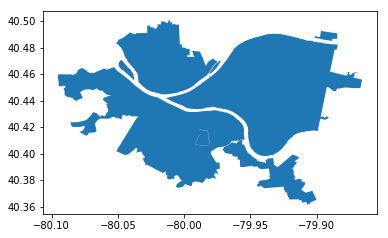

In [46]:
p.plot()

In [47]:
p.to_file('allegheny_county/pgh/pgh.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/pgh/pgh.geojson', 
                          'allegheny_county/pgh.bin')

Read 8 features from allegheny_county/pgh/pgh.geojson
3533 segments
Created allegheny_county/pgh.bin (3533 segments)


# Zipcode boundaries

In [356]:
# List of Allegheny county zipcodes adapted from https://clicknathan.com/2012/10/10/csv-of-all-zip-codes-in-allegheny-county-and-pittsburgh/
ac_zips = [15006,15007,15101, 15006,15102,15014,15104,15015,15017,15106,15024,15025,15026,15108,15030,15046,15034,15110,15035,15112,15037,15044,15045,15116,15120,15126,15056,15129,15136,15130,15131,15132,15133,15135,15146,15064,15065,15137,15071,15139,15140,15201,15202,15203,15204,15205,15206,15207,15208,15209,15210,15211,15212,15213,15214,15215,15216,15217,15218,15219,15220,15221,15222,15223,15224,15225,15226,15227,15228,15229,15232,15233,15234,15235,15236,15237,15238,15239,15241,15242,15243,15275,15276,15142,15076,15143,15144,15084,15145,15147,15086,15122,15123,15090,15148]

In [13]:
# Zipcode boundaries from http://openac-alcogis.opendata.arcgis.com/datasets/allegheny-county-zip-code-boundaries
z = gpd.read_file('allegheny_county/zip/Allegheny_County_Zip_Code_Boundaries.shp').to_crs(epsg=4326)
z.set_index('ZIP')

,OBJECTID,NAME,ZIPTYPE,STATE,STATEFIPS,COUNTYFIPS,COUNTYNAME,S3DZIP,LAT,LON,EMPTYCOL,TOTRESCNT,MFDU,SFDU,BOXCNT,BIZCNT,RELVER,COLOR,GlobalID,SHAPESTAre,SHAPESTLen,geometry
ZIP,,,,,,,,,,,,,,,,,,,,,,
15224,94,PITTSBURGH,NON-UNIQUE,PA,42,42003,ALLEGHENY,152,40.464263,-79.945118,None,5113.0,845.0,4063.0,205.0,495.0,1.9.3,0,{38CD0F50-BE92-4378-A4FA-018342B795B0},2.859700e+07,30610.635874,POLYGON ((-79.93514051516793 40.47246201599135...
15012,4109,BELLE VERNON,NON-UNIQUE,PA,42,42129,WESTMORELAND,150,40.156140,-79.812132,None,7110.0,180.0,6786.0,144.0,651.0,1.9.3,10,{5622E8D7-42F6-4954-BCA1-027E79E94D85},3.777748e+06,8748.135750,POLYGON ((-79.83775440811193 40.20886713725888...
15142,853,PRESTO,NON-UNIQUE,PA,42,42003,ALLEGHENY,151,40.380401,-80.120993,None,1037.0,0.0,919.0,118.0,30.0,1.9.3,5,{50A22C3C-87AF-4B8F-89F4-05FD32B80F25},5.476600e+07,53641.071377,"POLYGON ((-80.1352916068595 40.37535085360339,..."
15216,302,PITTSBURGH,NON-UNIQUE,PA,42,42003,ALLEGHENY,152,40.401802,-80.034334,None,11008.0,1817.0,9054.0,137.0,535.0,1.9.3,6,{3138C4F5-5CEE-43E0-8933-0F0E7AA1EEBA},9.943664e+07,73665.706897,POLYGON ((-80.02014732332069 40.42471996522837...
15110,49,DUQUESNE,NON-UNIQUE,PA,42,42003,ALLEGHENY,151,40.372431,-79.850058,None,2833.0,318.0,2383.0,132.0,169.0,1.9.3,6,{0572D3C0-9701-472C-B109-0FB3F73FC8EA},5.617067e+07,33483.390748,POLYGON ((-79.83915077913046 40.37589093471708...
15140,63,PITCAIRN,NON-UNIQUE,PA,42,42003,ALLEGHENY,151,40.405381,-79.775416,None,1616.0,183.0,1382.0,51.0,83.0,1.9.3,6,{4E4D0A6D-8B46-4F3B-A41B-120E609506E2},1.563680e+07,24765.980932,"POLYGON ((-79.7713712448505 40.40007597104859,..."
15026,893,CLINTON,NON-UNIQUE,PA,42,42007,BEAVER,150,40.512342,-80.373905,None,1457.0,0.0,1205.0,252.0,90.0,1.9.3,0,{060219CD-1215-491C-ADD3-15E31994CA1A},1.456795e+08,89993.628910,(POLYGON ((-80.28947887015411 40.5280711683538...
15239,107,PITTSBURGH,NON-UNIQUE,PA,42,42003,ALLEGHENY,152,40.487435,-79.739462,None,8522.0,164.0,8256.0,102.0,532.0,1.9.3,6,{F85E598B-BC93-40B3-9C95-192AC8A5F4EC},4.738983e+08,137521.732924,POLYGON ((-79.70200794631778 40.52320520070309...
15120,313,HOMESTEAD,NON-UNIQUE,PA,42,42003,ALLEGHENY,151,40.396064,-79.906267,None,9303.0,1035.0,8024.0,244.0,651.0,1.9.3,6,{333855ED-238E-4219-BF3A-1B03E620B6BE},1.392989e+08,59764.240978,POLYGON ((-79.88470695335526 40.39742637758213...


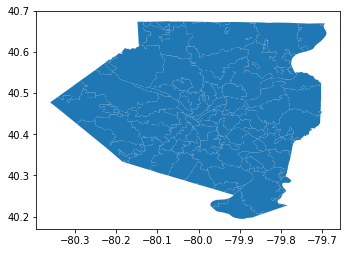

In [364]:
z.plot()

In [363]:
z.to_file('allegheny_county/zip/allegheny_county_zips.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/zip/allegheny_county_zips.geojson', 
                          'allegheny_county/allegheny_county_zips.bin')

Read 122 features from allegheny_county/zip/allegheny_county_zips.geojson
53251 segments
Created allegheny_county/allegheny_county_zips.bin (53251 segments)


In [29]:
us_zips = pd.read_csv("allegheny_county/zip/us-national-zips-2010.csv")
us_zips.set_index('zipcode')
pa_zips = us_zips[us_zips.state=='PA']
pa_zips

,zipcode,city,state,Unnamed: 3,Unnamed: 4,Unnamed: 5
13,19035,Gladwyne,PA,NaN,NaN,NaN
21,19085,Villanova,PA,NaN,NaN,NaN
137,19009,Bryn Athyn,PA,NaN,NaN,NaN
146,19066,Merion Station,PA,NaN,NaN,NaN
154,19041,Haverford,PA,NaN,NaN,NaN
156,19421,Birchrunville,PA,NaN,NaN,NaN
196,18357,Skytop,PA,NaN,NaN,NaN
245,16155,Villa Maria,PA,NaN,NaN,NaN
252,19437,Gwynedd Valley,PA,NaN,NaN,NaN
263,19072,Narberth,PA,NaN,NaN,NaN


In [36]:
len(pa_zips[pa_zips.zipcode==15213])

1

In [38]:
len(z[z.ZIP=='15213'])

1

In [39]:
def compare_zips(property_zip, owner_zip):
    if(int(property_zip) == int(owner_zip)):
        return 'zip'
    elif(len(z[z.ZIP==str(owner_zip)])>0):
        return 'county'
    elif(len(pa_zips[pa_zips.zipcode==int(owner_zip)])>0):
        return 'state'
    else:
        return 'out-of-state'

In [41]:
compare_zips(15213,15213)

'zip'

In [42]:
compare_zips(15213,15012)

'county'

In [43]:
compare_zips(15213,'15712')

'state'

In [44]:
compare_zips('15213','68506')

'out-of-state'

# Census boundaries

In [125]:
#!wget https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_42003_tract10.zip
#!/usr/bin/ogr2ogr -f GeoJSON -t_srs crs:84 allegheny_county/tl_2010_42003_tract10.geojson allegheny_county/tl_2010_42003_tract10.shp

binarize_geojson_outlines('allegheny_county/tl_2010_42003_tract10.geojson',
                          'allegheny_county/allegeny_county_tracts_2010.bin')

Read 402 features from allegheny_county/tl_2010_42003_tract10.geojson
118186 segments
Created allegheny_county/allegeny_county_tracts_2010.bin (118186 segments)


In [126]:
#!/usr/bin/ogr2ogr -f GeoJSON -t_srs crs:84 allegheny_county/tl_2010_42003_bg10.geojson allegheny_county/tl_2010_42003_bg10.shp

binarize_geojson_outlines('allegheny_county/tl_2010_42003_bg10.geojson',
                          'allegheny_county/allegeny_county_blockgroups_2010.bin')

Read 1100 features from allegheny_county/tl_2010_42003_bg10.geojson
220899 segments
Created allegheny_county/allegeny_county_blockgroups_2010.bin (220899 segments)


In [127]:
#!/usr/bin/ogr2ogr -f GeoJSON -t_srs crs:84 allegheny_county/tl_2010_42003_tabblock10.geojson allegheny_county/tl_2010_42003_tabblock10.shp

binarize_geojson_outlines('allegheny_county/tl_2010_42003_tabblock10.geojson',
                          'allegheny_county/allegeny_county_blocks_2010.bin')

Read 30519 features from allegheny_county/tl_2010_42003_tabblock10.geojson
1141888 segments
Created allegheny_county/allegeny_county_blocks_2010.bin (1141888 segments)


In [128]:
def numpy_memmap_read(path, dtype):
    nelems = os.stat(path).st_size / numpy.dtype(dtype).itemsize
    return numpy.memmap(path, dtype=dtype, shape=(nelems,), mode='r')

numpy_memmap_read('allegheny_county/allegeny_county_tracts_2010.bin', numpy.float32)

memmap([ 71.16960907,  96.48995209,  71.1697464 , ...,  96.5345459 ,
        71.14060211,  96.5345993 ], dtype=float32)